In [1]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import datapreprocessing as dp
import numpy as np
import pandas as pd
import seaborn as sns

# Cross Validation

Do I need a developement set (to find best model) and an evaluation set with data that has not been seen before? -> YES
Do i need to do nested cross vlaidataion? -> NO
Do I need to differenciate between putting in all models and not? -> NO

## Ridge Nested Cross Validation
based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py

could potentially do stratified kfold cv https://stackoverflow.com/questions/54945196/sklearn-stratified-k-fold-cv-with-linear-model-like-elasticnetcv



In [176]:
pred, X, velocity_genes, y = dp.get_data(louvain=True)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [138]:
#parameters

n_splits = 10
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y['louvain'], test_size = 0.25, shuffle=True, random_state=random_state)


# Ridge
ridge = Ridge(random_state=random_state)
ridge_grid = [{'alpha':[0.5, 1, 2, 3, 4, 5, 10, 15, 20, 50, 100, 200, 300]}]

# RF took longer. 
rf = RandomForestRegressor(random_state=random_state)
rf_grid = [{'max_features':[3, 10, 50]}, {'max_depth': [10, 30, 60]}]


# Lasso difficulty converging. 
lasso = Lasso(random_state=random_state, max_iter=100000000)
lasso_grid = [{'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.015, 0.15,]}]


In [6]:
def gridSearch_validation(X, y, estimator, param_grid, n_splits, path=None):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    

    
    # Non_nested parameter search and scoring; holding back data. 
    clf = GridSearchCV(estimator=estimator, 
                       param_grid=param_grid, 
                       scoring = {'r2': 'r2', 'neg_mean_squared_error':'neg_mean_squared_error'}, 
                       cv=inner_cv, verbose=1, 
                       return_train_score=True,
                       refit = 'r2')

    clf.fit(X, y)
    
    if path is not None:
        a_file = open(path, "wb")
        pickle.dump(clf, a_file)
        a_file.close()
    
    return clf

In [ ]:
#change:
estimator = Ridge(random_state=random_state)
param_grid = [{'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}]
clf = gridSearch_validation(X_train.loc[:, X_train.columns != 'louvain'], 
                        y_train.loc[:, y_train.columns != 'louvain'],
                        lasso, param_grid, n_splits)

In [41]:
import pickle

model='ridge.pkl'

a_file = open("model_selection/"+model, "rb")
ridge = pickle.load(a_file)

In [33]:
model='lasso/'

a_file = open("model_selection/"+model+'Pask.pkl', "rb")
aff3 = pickle.load(a_file)

In [11]:
def r2_plot(clf):
    ax = sns.scatterplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_test_r2'], label = 'test')
    sns.scatterplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_train_r2'], label = 'train')
    ax.legend()
    ax.set_title('R2 values against for different alphas')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('R2 value')

def mse_plot(clf):
    sns.lineplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_test_neg_mean_squared_error'])
    sns.lineplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_train_neg_mean_squared_error'])



In [56]:
[ for key, value ridge.cv_results_.items()]

dict_items([('mean_fit_time', array([0.10143046, 0.10337927, 0.10799942, 0.10974221, 0.1050106 ,
       0.10479748, 0.11033921, 0.10220754, 0.10110381, 0.10026851,
       0.09951153, 0.10551953, 0.10779622, 0.10581748, 0.10360782])), ('std_fit_time', array([0.01339281, 0.00629255, 0.00216543, 0.00699363, 0.00288371,
       0.00095789, 0.01431385, 0.00100703, 0.00133122, 0.00060029,
       0.00088011, 0.00424747, 0.00289811, 0.0028711 , 0.00254564])), ('mean_score_time', array([0.0393609 , 0.05076482, 0.06277308, 0.06797879, 0.05818067,
       0.06077871, 0.05589283, 0.05565956, 0.05695188, 0.05410488,
       0.05508633, 0.05715933, 0.06039879, 0.05600107, 0.05800231])), ('std_score_time', array([0.01036916, 0.01482674, 0.00667856, 0.01442569, 0.00381508,
       0.00854198, 0.00290321, 0.0013652 , 0.0053596 , 0.00083109,
       0.00188389, 0.00544103, 0.00433865, 0.00328179, 0.00534363])), ('param_alpha', masked_array(data=[0.5, 4, 10, 15, 20, 35, 38, 40, 45, 50, 55, 60, 70,
           

In [64]:
ridge.cv_results_.values()

dict_values([array([0.10143046, 0.10337927, 0.10799942, 0.10974221, 0.1050106 ,
       0.10479748, 0.11033921, 0.10220754, 0.10110381, 0.10026851,
       0.09951153, 0.10551953, 0.10779622, 0.10581748, 0.10360782]), array([0.01339281, 0.00629255, 0.00216543, 0.00699363, 0.00288371,
       0.00095789, 0.01431385, 0.00100703, 0.00133122, 0.00060029,
       0.00088011, 0.00424747, 0.00289811, 0.0028711 , 0.00254564]), array([0.0393609 , 0.05076482, 0.06277308, 0.06797879, 0.05818067,
       0.06077871, 0.05589283, 0.05565956, 0.05695188, 0.05410488,
       0.05508633, 0.05715933, 0.06039879, 0.05600107, 0.05800231]), array([0.01036916, 0.01482674, 0.00667856, 0.01442569, 0.00381508,
       0.00854198, 0.00290321, 0.0013652 , 0.0053596 , 0.00083109,
       0.00188389, 0.00544103, 0.00433865, 0.00328179, 0.00534363]), masked_array(data=[0.5, 4, 10, 15, 20, 35, 38, 40, 45, 50, 55, 60, 70,
                   100, 150],
             mask=[False, False, False, False, False, False, False, False,

In [66]:
list(zip(ridge.cv_results_.keys(), [x[ridge.best_index_] for x in ridge.cv_results_.values()]))

[('mean_fit_time', 0.11033921241760254),
 ('std_fit_time', 0.014313847857023798),
 ('mean_score_time', 0.05589282512664795),
 ('std_score_time', 0.0029032149518981106),
 ('param_alpha', 38),
 ('params', {'alpha': 38}),
 ('split0_test_r2', 0.25915641823369934),
 ('split1_test_r2', 0.2600460838452319),
 ('split2_test_r2', 0.2544646970116033),
 ('split3_test_r2', 0.2524342482795806),
 ('split4_test_r2', 0.25312851702362343),
 ('split5_test_r2', 0.25792560946157705),
 ('split6_test_r2', 0.259057185648265),
 ('split7_test_r2', 0.26161044758375285),
 ('split8_test_r2', 0.25349030694234),
 ('split9_test_r2', 0.26176797164029386),
 ('mean_test_r2', 0.2573081485669967),
 ('std_test_r2', 0.003415229611024805),
 ('rank_test_r2', 1),
 ('split0_train_r2', 0.2830994272618409),
 ('split1_train_r2', 0.2829111650297047),
 ('split2_train_r2', 0.28360711306707365),
 ('split3_train_r2', 0.28382861551714983),
 ('split4_train_r2', 0.28371296379357264),
 ('split5_train_r2', 0.2832012912067674),
 ('split6_tra

In [243]:
# load all cv
import os

def compile_gridsearches(filepath):
    
    best ={}
    
    
    for (dirpath, dirnames, filenames) in os.walk(filepath):
        print(filenames)
        for name in filenames:
            with open(filepath+name, 'rb') as file:
                gcv = pickle.load(file)
                idx = gcv.best_index_
                
                target, apx = name.split('.')
                
                best[target]={'best_param': gcv.cv_results_['param_max_features'][idx], 
                              'mean_test_r2': gcv.cv_results_['mean_test_r2'][idx], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'][idx],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'][idx], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'][idx],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'][idx],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'][idx],
                              'std_test_r2': gcv.cv_results_['std_test_r2'][idx],
                              'std_train_r2':gcv.cv_results_['std_train_r2'][idx],
                              }
    return best


In [246]:
filenames = ['Pdcd1.pkl', 'Actr3.pkl', 'Stk17b.pkl', 'Mcm6.pkl', 'Ikzf2.pkl', 'Nab1.pkl', 'Tmem163.pkl', 'Ncl.pkl', 'Prim2.pkl', 'Lax1.pkl', 'Fhl2.pkl', 'Smap1.pkl', 'Mcm3.pkl', 'Rev1.pkl', 'Bcl2.pkl', 'Mrpl15.pkl', 'Hjurp.pkl', 'Wdr12.pkl', 'Zranb3.pkl', 'Ikbke.pkl', 'Bard1.pkl', 'Pask.pkl', 'Mybl1.pkl', 'Cd55.pkl', 'Aff3.pkl', 'Pecr.pkl', 'Dyrk3.pkl', '1700019D03Rik.pkl', 'Rgs1.pkl', 'Rgs2.pkl', 'Uck2.pkl', 'Mndal.pkl', 'Atp2b4.pkl', 'Tor3a.pkl', 'Gm4955.pkl', 'BC094916.pkl', 'Pydc4.pkl', 'Capn2.pkl', 'Fasl.pkl', 'Hsd11b1.pkl', 'Dtl.pkl', 'Map4k4.pkl', 'Smyd2.pkl', 'Rrp15.pkl', 'Nuf2.pkl', 'Il18r1.pkl', 'Atp1b1.pkl', 'Cenpf.pkl', 'Wdr75.pkl', 'Il18rap.pkl', 'Stat1.pkl', 'Atf3.pkl', 'Ifi204.pkl', 'Il1r2.pkl', 'Il1rl1.pkl', 'Icos.pkl', 'Nop58.pkl', 'Ptma.pkl', 'Sp100.pkl', 'Rqcd1.pkl', 'Atic.pkl', 'Psmd1.pkl', 'Sgol2a.pkl', 'Nucks1.pkl', 'Nifk.pkl', 'Ube2t.pkl', 'Uchl5.pkl', 'Rgs16.pkl', 'Fam129a.pkl', 'Cd48.pkl', 'Cd244.pkl', 'Pfdn2.pkl', 'Aspm.pkl', 'Kif14.pkl', 'Chit1.pkl', 'Slamf6.pkl', 'Cenpl.pkl', 'Tagln2.pkl', 'Gm10522.pkl', 'Sell.pkl', 'Tnfsf4.pkl', 'Desi2.pkl', 'Pyhin1.pkl', 'Ipcef1.pkl', 'Parp1.pkl', 'Phactr2.pkl', 'Eprs.pkl', 'Exo1.pkl', 'Myb.pkl', 'Ddx21.pkl', 'Slc16a10.pkl', 'Foxo3.pkl', 'Fbxo5.pkl', 'Nsl1.pkl', 'Rpf2.pkl', 'Prdm1.pkl', 'Batf3.pkl', 'Gna15.pkl', 'Hsp90b1.pkl', 'Cdk1.pkl', 'Fzr1.pkl', 'Cct2.pkl', 'Rap1b.pkl', 'Parpbp.pkl', 'Tmpo.pkl', 'Adarb1.pkl', 'Utp20.pkl', 'Pwp2.pkl', 'Nup107.pkl', 'Ifngr1.pkl', 'Pa2g4.pkl', 'Dgka.pkl', 'Gas2l3.pkl', 'Zc3h12d.pkl', 'Nup43.pkl', 'Irak3.pkl', 'Sgk1.pkl', 'Fyn.pkl', 'Hdac2.pkl', 'Prep.pkl', 'Mtfr2.pkl', 'Samd3.pkl', 'Snrpd3.pkl', 'Scml4.pkl', 'Lilrb4a.pkl', 'Tube1.pkl', 'Spock2.pkl', 'Hmha1.pkl', 'Dna2.pkl', 'Palm.pkl', 'Eea1.pkl', 'Ppp1r12a.pkl', 'Ggt1.pkl', 'Atp2b1.pkl', 'Cep83.pkl', '1500009L16Rik.pkl', 'Nap1l1.pkl', 'Pwp1.pkl', 'Egr2.pkl', 'Ptges3.pkl', 'E2f7.pkl', 'Mdm1.pkl', 'Phlda1.pkl', 'Mettl1.pkl', 'Prim1.pkl', 'Timeless.pkl', 'Stat2.pkl', 'Rel.pkl', 'H2afv.pkl', 'Myo1g.pkl', 'Dock2.pkl', 'Npm1.pkl', 'Tbrg4.pkl', 'Ddx56.pkl', 'Canx.pkl', 'Anxa6.pkl', 'Il3.pkl', 'Gemin5.pkl', 'Tmem11.pkl', 'Pfas.pkl', 'Kdm6b.pkl', 'Spdl1.pkl', 'Hmmr.pkl', 'Pelp1.pkl', 'Rap1gap2.pkl', 'Tcf7.pkl', 'Shmt1.pkl', 'Aatf.pkl', 'Luc7l3.pkl', 'Slfn8.pkl', 'Utp18.pkl', 'Brip1.pkl', 'Tada2a.pkl', 'Nle1.pkl', 'Prr11.pkl', 'Top2a.pkl', 'Ikzf3.pkl', 'Cpd.pkl', 'Fam101b.pkl', 'Arl5c.pkl', 'Abi3.pkl', 'Eme1.pkl', 'Pitpnc1.pkl', 'Dhx58.pkl', 'Brca1.pkl', 'Nol11.pkl', 'Ftsj3.pkl', 'Galk1.pkl', 'Pecam1.pkl', 'Srsf2.pkl', 'Tmc6.pkl', 'Mpp2.pkl', 'Adam19.pkl', 'Cbx4.pkl', 'Tk1.pkl', 'Kif18b.pkl', 'Xpo1.pkl', 'Ccm2.pkl', 'Lcp2.pkl', 'G3bp1.pkl', 'Havcr2.pkl', 'Timp2.pkl', 'Larp1.pkl', 'Pik3ip1.pkl', 'Tnfrsf13b.pkl', 'Pik3r5.pkl', 'Slc36a1.pkl', 'Trappc1.pkl', 'Nsg2.pkl', 'Clec10a.pkl', 'Gas7.pkl', 'Suz12.pkl', 'Aurkb.pkl', 'Xaf1.pkl', 'Mettl16.pkl']
filepath = './model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/'
best ={}

for name in filenames:
    with open(filepath+name, 'rb') as file:
        gcv = pickle.load(file)
        idx = gcv.best_index_

        target, apx = name.split('.')

        best[target]={'best_feature': gcv.cv_results_['param_max_features'][idx], 
                      'best_depth': gcv.cv_results_['param_max_depth'][idx],
                      'mean_test_r2': gcv.cv_results_['mean_test_r2'][idx], 
                      'mean_train_r2': gcv.cv_results_['mean_train_r2'][idx],
                      'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'][idx], 
                      'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'][idx],
                      'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'][idx],
                      'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'][idx],
                      'std_test_r2': gcv.cv_results_['std_test_r2'][idx],
                      'std_train_r2':gcv.cv_results_['std_train_r2'][idx],
                      }

Okay, so random forest returns two parameters, which is why i return dict params. --> trouble for later functions.. 

In [244]:
best = compile_gridsearches('./model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/')

['Pdcd1.pkl', 'Actr3.pkl', 'Stk17b.pkl', 'Mcm6.pkl', 'Ikzf2.pkl', 'Nab1.pkl', 'Tmem163.pkl', 'Ncl.pkl', 'Prim2.pkl', 'Lax1.pkl', 'Fhl2.pkl', 'Smap1.pkl', 'Mcm3.pkl', 'Rev1.pkl', 'Bcl2.pkl', 'Mrpl15.pkl', 'Hjurp.pkl', 'Wdr12.pkl', 'Zranb3.pkl', 'Ikbke.pkl', 'Bard1.pkl', 'Pask.pkl', 'Mybl1.pkl', 'Cd55.pkl', 'Aff3.pkl', 'Pecr.pkl', 'Dyrk3.pkl', '1700019D03Rik.pkl', 'Rgs1.pkl', 'Rgs2.pkl', 'Uck2.pkl', 'Mndal.pkl', 'Atp2b4.pkl', 'Tor3a.pkl', 'Gm4955.pkl', 'BC094916.pkl', 'Pydc4.pkl', 'Capn2.pkl', 'Fasl.pkl', 'Hsd11b1.pkl', 'Dtl.pkl', 'Map4k4.pkl', 'Smyd2.pkl', 'Rrp15.pkl', 'Nuf2.pkl', 'Il18r1.pkl', 'Atp1b1.pkl', 'Cenpf.pkl', 'Wdr75.pkl', 'Il18rap.pkl', 'Stat1.pkl', 'Atf3.pkl', 'Ifi204.pkl', 'Il1r2.pkl', 'Il1rl1.pkl', 'Icos.pkl', 'Nop58.pkl', 'Ptma.pkl', 'Sp100.pkl', 'Rqcd1.pkl', 'Atic.pkl', 'Psmd1.pkl', 'Sgol2a.pkl', 'Nucks1.pkl', 'Nifk.pkl', 'Ube2t.pkl', 'Uchl5.pkl', 'Rgs16.pkl', 'Fam129a.pkl', 'Cd48.pkl', 'Cd244.pkl', 'Pfdn2.pkl', 'Aspm.pkl', 'Kif14.pkl', 'Chit1.pkl', 'Slamf6.pkl', 'Cenpl

KeyboardInterrupt: 

In [247]:
df = pd.DataFrame(best)
df

,Pdcd1,Actr3,Stk17b,Mcm6,Ikzf2,Nab1,Tmem163,Ncl,Prim2,Lax1,...,Pik3r5,Slc36a1,Trappc1,Nsg2,Clec10a,Gas7,Suz12,Aurkb,Xaf1,Mettl16
best_feature,100.000000,40.000000,40.000000,40.000000,100.000000,40.000000,100.000000,40.000000,40.000000,100.000000,...,40.000000,100.000000,100.000000,40.000000,40.000000,40.000000,100.000000,40.000000,40.000000,40.000000
best_depth,30.000000,30.000000,30.000000,40.000000,30.000000,40.000000,30.000000,40.000000,40.000000,30.000000,...,30.000000,30.000000,40.000000,30.000000,40.000000,30.000000,40.000000,30.000000,40.000000,40.000000
mean_test_r2,0.623163,0.528294,0.397762,0.518848,0.404713,0.359058,0.393127,0.564109,0.611069,0.282048,...,0.350895,0.248651,0.460132,0.292774,0.234479,0.466734,0.453322,0.489055,0.258673,0.344906
mean_train_r2,0.946882,0.932889,0.914715,0.932205,0.916281,0.909431,0.913417,0.938086,0.944841,0.897776,...,0.905922,0.881700,0.924162,0.878105,0.892759,0.921879,0.923166,0.925705,0.894812,0.908394
mean_test_neg_mean_squared_error,-0.377088,-0.465585,-0.602741,-0.476638,-0.604129,-0.648894,-0.606534,-0.429953,-0.387867,-0.725014,...,-0.649166,-0.753159,-0.533070,-0.716863,-0.748534,-0.528047,-0.549368,-0.511629,-0.737583,-0.653238
mean_train_neg_mean_squared_error,-0.053273,-0.066228,-0.085493,-0.067257,-0.085125,-0.091773,-0.086600,-0.061074,-0.055082,-0.103299,...,-0.094301,-0.118747,-0.075141,-0.124196,-0.103950,-0.077769,-0.077341,-0.074608,-0.104733,-0.091651
std_test_neg_mean_squared_error,0.019739,0.030229,0.028474,0.036144,0.042901,0.032345,0.037385,0.035183,0.026664,0.027433,...,0.038991,0.051200,0.024294,0.056999,0.294901,0.063558,0.032742,0.053529,0.045146,0.035415
std_train_neg_mean_squared_error,0.000620,0.000705,0.000768,0.000865,0.000503,0.000964,0.001122,0.000887,0.000625,0.000991,...,0.000693,0.001661,0.000592,0.001738,0.006749,0.000928,0.000704,0.000729,0.001144,0.000684
std_test_r2,0.022558,0.017831,0.017212,0.025704,0.024694,0.013011,0.022542,0.025446,0.014376,0.011381,...,0.019161,0.023535,0.029413,0.049768,0.086448,0.035072,0.014396,0.029991,0.016746,0.030920
std_train_r2,0.000469,0.000551,0.000812,0.000715,0.000692,0.000677,0.000849,0.000760,0.000612,0.001006,...,0.000886,0.001219,0.000534,0.002173,0.004548,0.000579,0.000565,0.000821,0.001193,0.000701


In [124]:
df.loc[:,df.loc['best_param']==5]

,Nap1l1,Hsp90ab1,Rasgrp2,Tpx2,Mki67
best_param,5.000000,5.000000,5.000000,5.000000,5.000000
mean_test_r2,0.881327,0.813386,0.894900,0.756346,0.706209
mean_train_r2,0.886104,0.821618,0.898620,0.766267,0.718465
mean_test_neg_mean_squared_error,-0.118759,-0.182583,-0.104111,-0.241948,-0.289200
mean_train_neg_mean_squared_error,-0.114652,-0.176394,-0.101035,-0.232995,-0.279244
std_test_neg_mean_squared_error,0.006143,0.007941,0.005453,0.015897,0.025558
std_train_neg_mean_squared_error,0.000674,0.000867,0.000592,0.001710,0.002747
std_test_r2,0.009911,0.018533,0.008518,0.020788,0.023521
std_train_r2,0.001111,0.001925,0.000944,0.002146,0.002663


In [281]:
df.iloc[:, df.loc['mean_test_r2'].argmax()]

best_feature                         100.000000
best_depth                            30.000000
mean_test_r2                           0.888992
mean_train_r2                          0.984434
mean_test_neg_mean_squared_error      -0.111239
mean_train_neg_mean_squared_error     -0.015669
std_test_neg_mean_squared_error        0.005510
std_train_neg_mean_squared_error       0.000195
std_test_r2                            0.007095
std_train_r2                           0.000239
Name: Nap1l1, dtype: float64

Average: 45.31605049594229 (21.875425525706312)


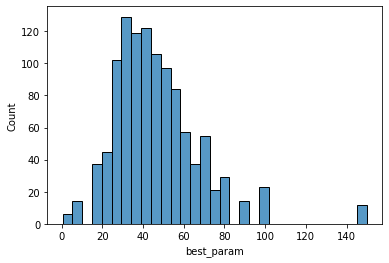

In [228]:
a = sns.histplot(df.loc['best_param'])
print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                np.std(df.loc['best_param'])))

Average: 36.372093023255815 (4.808051656911844)


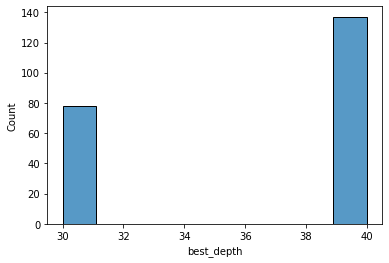

In [254]:
a = sns.histplot(df.loc['best_depth'])
print('Average: {} ({})'.format(np.mean(df.loc['best_depth']), 
                                np.std(df.loc['best_depth'])))

Average max_depth: 36.372093023255815 (4.808051656911844)
Average R2 for max_depth 30: 0.44525233671753167
Average R2 for max_depth 40: 0.41099819767543844


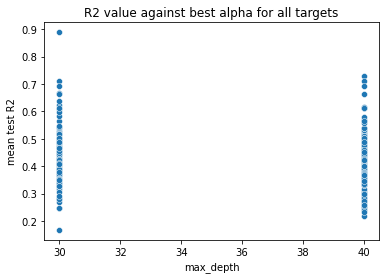

In [277]:
ax = sns.scatterplot(x = df.loc['best_depth'], y=df.loc['mean_test_r2'])
ax.set_title('R2 value against best alpha for all targets')
ax.set_xlabel('max_depth')
ax.set_ylabel('mean test R2')
print('Average max_depth: {} ({})'.format(np.mean(df.loc['best_depth']), 
                                np.std(df.loc['best_depth'])))
print('Average R2 for max_depth 30: {}'.format(df.loc[:,df.loc['best_depth']==30].loc['mean_test_r2'].mean()))
print('Average R2 for max_depth 40: {}'.format(df.loc[:,df.loc['best_depth']==40].loc['mean_test_r2'].mean()))

In [276]:
df.loc[:,df.loc['best_depth']==30].loc['mean_test_r2'].mean()

0.44525233671753167

In [264]:
df.groupby(by='best_depth', axis=1).mean_test_r2.mean()

KeyError: 'best_depth'

Average max_feature: 68.46976744186047 (30.78156753555473)
Average R2: 0.42342528067675594 (0.1110100721831874)
Average R2 for max_feature 30: 0.43194484831047125
Average R2 for max_feature 40: 0.4158547850435478


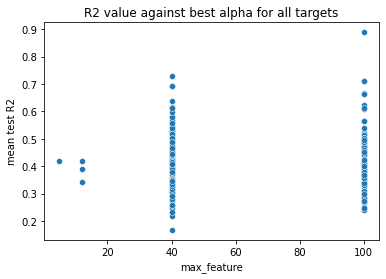

In [280]:
ax = sns.scatterplot(x = df.loc['best_feature'], y=df.loc['mean_test_r2'])
ax.set_title('R2 value against best alpha for all targets')
ax.set_xlabel('max_feature')
ax.set_ylabel('mean test R2')
print('Average max_feature: {} ({})'.format(np.mean(df.loc['best_feature']), 
                                np.std(df.loc['best_feature'])))
print('Average R2: {} ({})'.format(np.mean(df.loc['mean_test_r2']), 
                                np.std(df.loc['mean_test_r2'])))
print('Average R2 for max_feature 30: {}'.format(df.loc[:,df.loc['best_feature']==40].loc['mean_test_r2'].mean()))
print('Average R2 for max_feature 40: {}'.format(df.loc[:,df.loc['best_feature']==100].loc['mean_test_r2'].mean()))

Average: 68.46976744186047 (30.78156753555473)


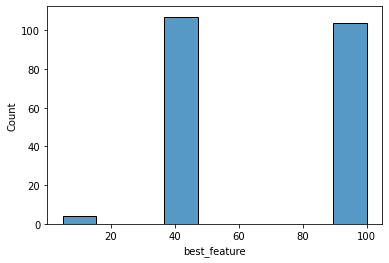

In [260]:
a = sns.histplot(df.loc['best_feature'])
print('Average: {} ({})'.format(np.mean(df.loc['best_feature']), 
                                np.std(df.loc['best_feature'])))

Do clusters here mean anything?

Average: 0.42342528067675594 (0.1110100721831874)


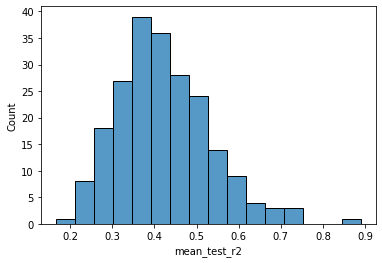

In [252]:
a = sns.histplot(df.loc['mean_test_r2'])
print('Average: {} ({})'.format(np.mean(df.loc['mean_test_r2']), 
                                np.std(df.loc['mean_test_r2'])))

Sind das dieselben gene, die gut vorhersehbar sind bei allen modellen? 

not sure what to do with random forest. 

MSE ->
top genes. 
Are there clusters of genes performing well or good

Irgendwie verwirrt mich das Lasso model. Ist es also doch nicht schlimm dass es nicht konvergiert? Warum ist der kleinste Wert der beste? 

Ridge runs through in 5 mins. THe lasso as well (with parallelization..)

In [238]:
a_file = open("/home/ubuntu/volume/model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/Mcm3.pkl", "rb")
mcm3 = pickle.load(a_file)

In [241]:
mcm3.best_params_


{'max_depth': 40, 'max_features': 40}

In [160]:
fit = mrpl1.best_estimator_.fit(X, y['Aatf'])

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422.0929421977744, tolerance: 1.369299996526737
  model = cd_fast.enet_coordinate_descent(


In [165]:
Lasso(alpha=0.001, random_state=42)

Lasso(alpha=0.001, random_state=42)